In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer

import nltk
nltk.download('wordnet')

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package wordnet to C:\Users\Positivo
[nltk_data]     BGH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
europe = ['Austria', 'Bosnia and Herzegovina','Bulgaria','Croatia','Cyprus','Czech Republic','England', 'France','Germany','Greece','Italy','Luxembourg','Portugal','Hungary', 'Macedonia', 'Moldova', 'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'Turkey', 'Ukraine', 'Georgia']
asia = ['Armenia', 'China','India','Israel','Lebanon' ]
northAmerica = ['Canada','US','Mexico']
sudAmerica = ['Argentina','Brazil','Chile','Peru','Uruguay'] 
oceania = ['Australia','New Zealand'] 
africa = ['South Africa','Morocco', 'Egypt']

#Chose to set as 'Other' all the continent with a small amout of reviews 
def continentDispacher(row):
    if row['country'] in europe:
        val = 'Europa'
    elif row['country'] in asia:
        val = 'Asia'
    elif row['country'] in northAmerica:
        val = 'America del norte'
    elif row['country'] in sudAmerica:
        val = 'America del sur'
    elif row['country'] in oceania:
        val = 'Oceania'
    elif row['country'] in africa:
        val = 'Africa'
    else:
        val = 'Other'

    return val

def preprocess_text(text):
  lemmatizer = WordNetLemmatizer()

    # Convertir a minúsculas
  text = text.lower()
    # Eliminar caracteres especiales
  text = re.sub(r'[^a-z\s]', '', text)
    # Eliminar stopwords y lematizar
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in ENGLISH_STOP_WORDS])
  return text

def analyze_sentiment(text):
    analysis = TextBlob(text)
    score = analysis.sentiment.polarity
    if score < 0:
      return "Negativa"
    elif score == 0:
      return "Neutral"
    else:
      return "Positiva"
    
def extraer_anio(texto):
    # Buscar años en formato de cuatro dígitos (19xx o 20xx)
    match = re.search(r'\b(19|20)\d{2}\b', texto)
    if match:
        return match.group()
    
    # Buscar años en formato de "X Años" o "X Years Old"
    match = re.search(r'(\d+)\s*(Años|Years\s*Old)', texto, re.IGNORECASE)
    if match:
        return str(int(2024) - int(match.group(1)))  # Ajusta el año actual según tu necesidad
    
    return None

def imputer(df_filter, col):
    imputer = SimpleImputer(strategy='median')
    df_filter.loc[:, col] = imputer.fit_transform(df_filter[[col]])
    return df_filter

def preprocess(df):
    df = df.copy()
    df_filter = df.dropna(subset=['country', 'designation'])

    df_filter = imputer(df_filter, 'price')
    df_filter.drop_duplicates(inplace=True)
    df_filter = df_filter.drop(columns=['region_2', 'taster_name', 'taster_twitter_handle'])
    df_filter['region_1'] = df_filter['region_1'].fillna("Unknown")

    df_filter['Continente'] = df_filter.apply(continentDispacher,1)
    df_filter['Descripcion'] = df_filter['description'].apply(preprocess_text)
    df_filter['Sentimiento'] = df_filter['description'].apply(analyze_sentiment)
    df_filter['Año'] = (df_filter['title'].apply(extraer_anio))
    df_filter = imputer(df_filter, 'Año')
    df_filter["Antiguedad"] = 2024 - df_filter.Año.astype(int)
    df_filter['Ratio_puntos_precio'] = df_filter['points'] / df_filter['price']

    data = df_filter.rename(columns={'country': 'Pais', 'designation': 'Viñedo_especifico', 'points': 'Puntos', 'price': 'Precio', 'province': 'Provincia', 'variety': 'Variedad', 'winery': 'Bodega'})
    return data.filter(['Pais', 'Continente', 'Provincia', 'region_1', 'Descripcion', 'Sentimiento', 'Viñedo_especifico', 'Variedad', 'Bodega', 'Año', 'Antiguedad', 'Puntos', 'Precio', 'Ratio_puntos_precio',], axis=1)

In [ ]:
df = pd.read_csv("vinos.csv").drop(['Unnamed: 0'], axis=1)
data = preprocess(df)
data.head()

In [3]:
#data.to_excel("Wine_filtered.xlsx", index=False)
data = pd.read_excel("Wine_filtered.xlsx")
data.head()

,Pais,Continente,Provincia,region_1,Descripcion,Sentimiento,Viñedo_especifico,Variedad,Bodega,Año,Antiguedad,Puntos,Precio,Ratio_puntos_precio
0,Italy,Europa,Sicily & Sardinia,Etna,aroma include tropical fruit broom brimstone d...,Positiva,Vulkà Bianco,White Blend,Nicosia,2013,11,87,28,3.107143
1,Portugal,Europa,Douro,Unknown,ripe fruity wine smooth structured firm tannin...,Positiva,Avidagos,Portuguese Red,Quinta dos Avidagos,2011,13,87,15,5.800000
2,US,America del norte,Michigan,Lake Michigan Shore,pineapple rind lemon pith orange blossom start...,Positiva,Reserve Late Harvest,Riesling,St. Julian,2013,11,87,13,6.692308
3,US,America del norte,Oregon,Willamette Valley,like regular bottling come rough tannic rustic...,Positiva,Vintner's Reserve Wild Child Block,Pinot Noir,Sweet Cheeks,2012,12,87,65,1.338462
4,Spain,Europa,Northern Spain,Navarra,blackberry raspberry aroma typical navarran wh...,Positiva,Ars In Vitro,Tempranillo-Merlot,Tandem,2011,13,87,15,5.800000


## En que zona del mundo se producen mas vinos?

<Axes: ylabel='count'>

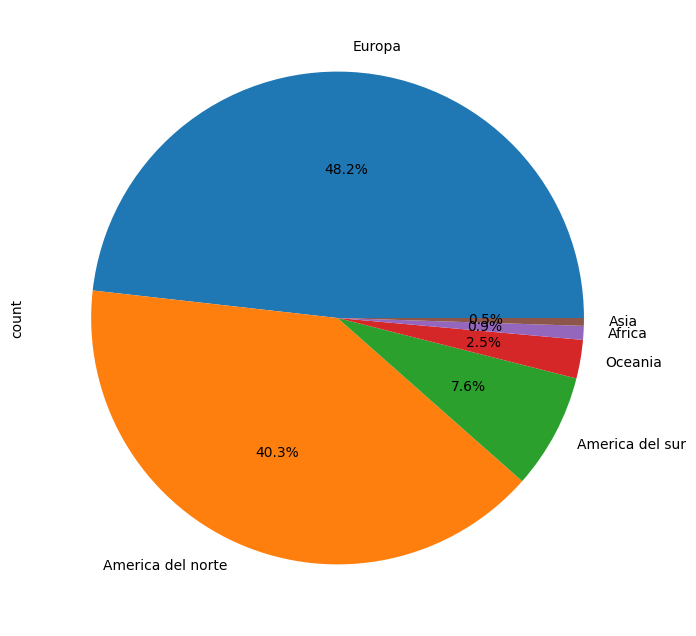

In [4]:
data.Continente.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))

## Cuales son los paises mas productores de vino?

<Axes: ylabel='Pais'>

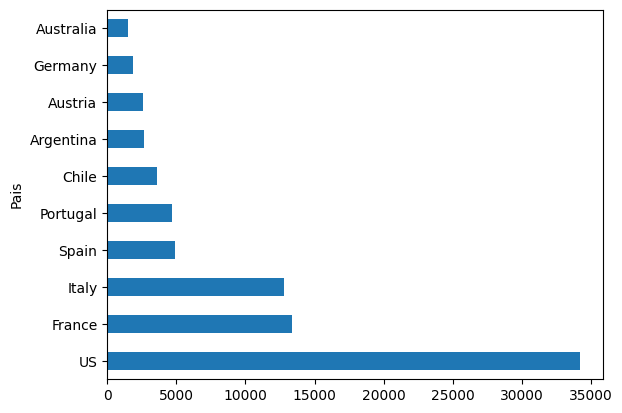

In [5]:
data['Pais'].value_counts().head(10).plot(kind='barh')

## Y cuales de estos paises tienen mejores puntuaciones y precios promedio?

Puntos

In [41]:
data.groupby('Pais')['Puntos'].mean().sort_values(ascending=False).round(2).head(10).to_frame()

,Puntos
Pais,
England,91.75
India,91.50
Austria,90.40
Germany,90.07
Hungary,89.48
Canada,89.33
France,89.17
US,89.01
China,89.00


Precio

In [40]:
data.groupby('Pais')['Precio'].mean().sort_values(ascending=False).round(2).head(10).to_frame()

,Precio
Pais,
England,51.11
Hungary,45.56
Germany,45.24
Australia,41.04
Italy,40.85
US,40.53
Canada,40.06
France,38.38
Austria,32.40


## Y cual tiene mejor relacion precio calidad?

In [39]:
mejor_relacion = data.sort_values(by='Ratio_puntos_precio', ascending=False)
mejores_vinos = mejor_relacion.head(10)
mejores_vinos.groupby('Pais')['Ratio_puntos_precio'].max().sort_values(ascending=False).to_frame()

,Ratio_puntos_precio
Pais,
Romania,21.50
Spain,21.25
Argentina,21.00
US,20.75
Chile,17.40
Italy,17.20


## En que provincias se encuentra la myor produccion de vino del mundo?

<Axes: ylabel='Pais'>

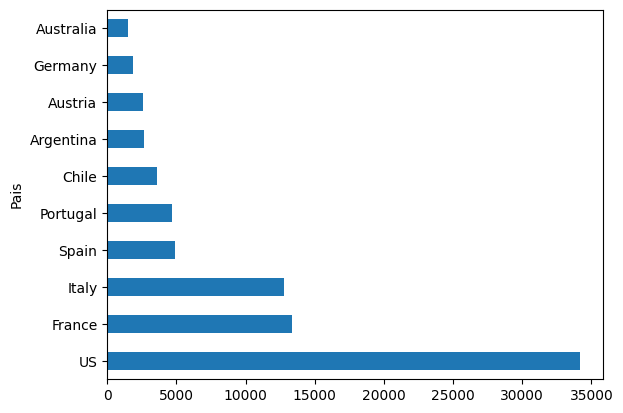

In [9]:
def group_provinces(count_prov, threshold=8):
    # Crear un nuevo DataFrame con la provincia como índice y el conteo como valor
    df = pd.DataFrame(count_prov, columns=['count'])

    # Identificar provincias que tienen menos de 'threshold' apariciones
    df['Provincia'] = df.index
    df['group'] = df['Provincia'].apply(lambda x: 'others' if df.loc[x, 'count'] < threshold else x)

    # Agrupar por el nuevo nombre de grupo y sumar los conteos
    grouped_df = df.groupby('group').sum().reset_index()
    
    # Reemplazar el nombre del grupo 'others' en el índice del DataFrame original
    result_df = grouped_df[['group', 'count']].groupby('group').sum().reset_index()

    return result_df

count_prov = data.Provincia.value_counts()
subset_prov = group_provinces(count_prov)

subset_prov.set_index(subset_prov.group, inplace=True)
subset_prov.drop('group', axis = 1, inplace=True)

more_prov = data[data['Provincia'].isin(subset_prov.index)].filter(['Pais', 'Provincia'])
more_prov.groupby('Pais')['Provincia'].count().sort_values(ascending=False).head(10).plot(kind='barh')


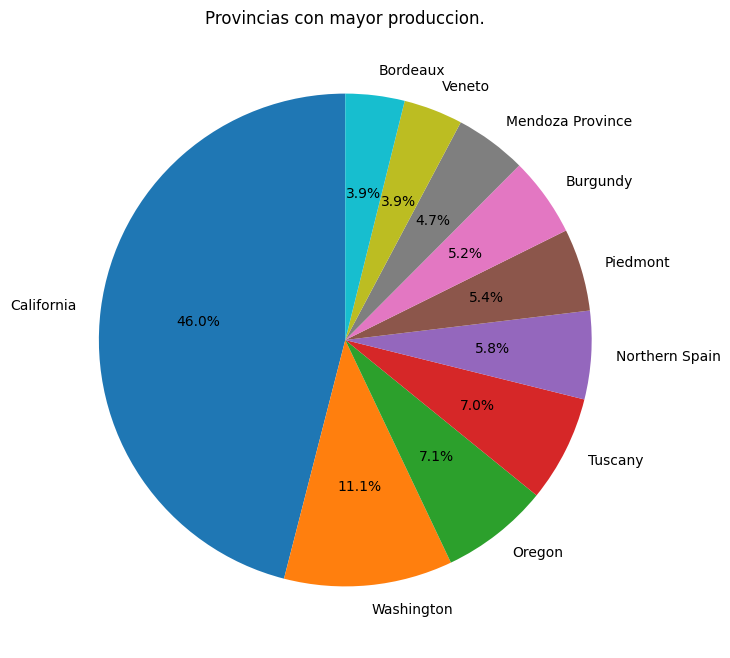

In [10]:
top_10 = subset_prov.sort_values(by='count', ascending=False).head(10)
# Crear el gráfico circular
top_10['count'].plot(kind='pie', labels=top_10.index, autopct='%1.1f%%', figsize=(10, 8), startangle=90)

# Personalizar el gráfico
plt.title('Provincias con mayor produccion.')
plt.ylabel('')  # Eliminar la etiqueta del eje y
plt.show()

## Los paises que tienen las provincias donde mas vino se produce son:

<Axes: ylabel='Provincia'>

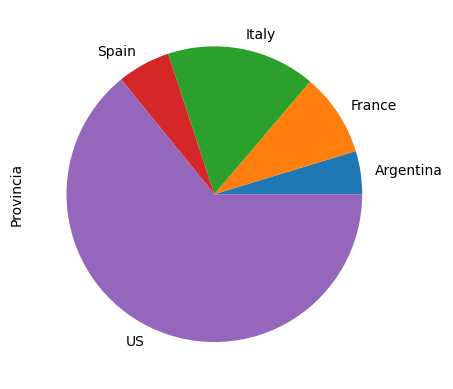

In [11]:
filtered_data = data[data['Provincia'].isin(top_10.index)].filter(['Pais', 'Provincia'])
filtered_data.groupby('Pais')['Provincia'].count().plot(kind='pie')

## Que vinos producen estos paises?

In [53]:
data.head(1)

,Pais,Continente,Provincia,region_1,Descripcion,Sentimiento,Viñedo_especifico,Variedad,Bodega,Año,Antiguedad,Puntos,Precio,Ratio_puntos_precio
0,Italy,Europa,Sicily & Sardinia,Etna,aroma include tropical fruit broom brimstone d...,Positiva,Vulkà Bianco,White Blend,Nicosia,2013,11,87,28,3.107143


In [64]:
paises = ['US', 'Argentina', 'France', 'Italy', 'Spain']
wines_per_country = data.loc[data.Pais.isin(paises)].filter(['Pais', 'Variedad'])
wines_per_country.head()

,Pais,Variedad
0,Italy,White Blend
2,US,Riesling
3,US,Pinot Noir
4,Spain,Tempranillo-Merlot
5,Italy,Frappato


In [80]:
def get_wine(variedades):
    return variedades.unique()

# Agrupar por país y aplicar la función
agrup = wines_per_country.groupby('Pais')['Variedad'].apply(get_wine).reset_index()

for i in range(5):
    n = len(agrup.Variedad[i])
    print(f"{agrup.Pais[i]} produce: {str(agrup.Variedad[i])}. Este pais tiene {n} variedades.")
    print("-"*100)

Argentina produce: ['Malbec' 'Chardonnay' 'Red Blend' 'Cabernet Sauvignon' 'Torrontés'
 'Bordeaux-style Red Blend' 'Pinot Gris' 'Sauvignon Blanc' 'Merlot' 'Rosé'
 'Viognier' 'White Blend' 'Rosado' 'Cabernet Sauvignon-Merlot' 'Moscato'
 'Cabernet Franc' 'Tempranillo' 'Syrah' 'Cabernet Blend' 'Bonarda'
 'Pinot Noir' 'Cabernet Sauvignon-Malbec' 'Malbec-Cabernet Sauvignon'
 'Nebbiolo' 'Sparkling Blend' 'Malbec-Syrah' 'Pinot Grigio'
 'Syrah-Viognier' 'Champagne Blend' 'Merlot-Cabernet Franc' 'Riesling'
 'Tannat' 'Tocai' 'Petit Verdot' 'Malbec-Petit Verdot' 'Sangiovese'
 'Malbec-Cabernet' 'Sémillon' 'Chenin Blanc-Chardonnay'
 'Chardonnay-Viognier' 'Cabernet Franc-Malbec' 'Tempranillo-Malbec'
 'Malbec-Cabernet Franc' 'Malbec-Bonarda' 'Cabernet-Syrah'
 'Cabernet Franc-Cabernet Sauvignon' 'Barbera' 'Malbec-Merlot'
 'Chenin Blanc' 'Shiraz' 'Bordeaux-style White Blend' 'Malbec Blend'
 'Malbec-Tannat' 'Chardonnay-Sauvignon' 'Cabernet Sauvignon-Shiraz'
 'Trousseau' 'Cabernet-Malbec' 'Syrah-Bonarda'

## Palabras comunes usadas en la descripcion

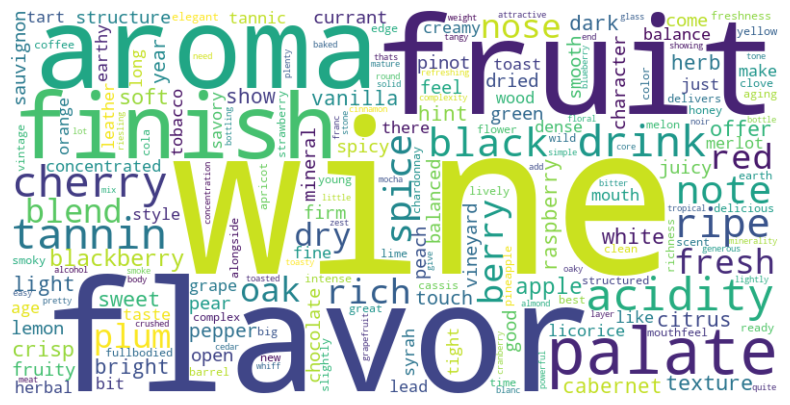

In [13]:
from collections import Counter

word_counts = Counter(" ".join(data['Descripcion']).split())

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
# Convertir el texto en una matriz de palabras
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(data['Descripcion'])

# Aplicar LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [17]:
import joblib
joblib.dump(lda, 'lda_model.pkl')

lda_loaded = joblib.load('lda_model.pkl')

## Cuales son los temas mas comunes en las descripciones?

In [18]:
for index, topic in enumerate(lda.components_):
    print(f'Topic #{index}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic #0:
['herbal', 'plum', 'feel', 'note', 'fruit', 'berry', 'palate', 'finish', 'aroma', 'flavor']
Topic #1:
['fruit', 'spice', 'blackberry', 'aroma', 'palate', 'flavor', 'wine', 'tannin', 'black', 'cherry']
Topic #2:
['syrah', 'cherry', 'oak', 'merlot', 'sauvignon', 'wine', 'flavor', 'blend', 'fruit', 'cabernet']
Topic #3:
['white', 'note', 'lemon', 'peach', 'apple', 'acidity', 'finish', 'wine', 'palate', 'flavor']
Topic #4:
['character', 'texture', 'rich', 'tannin', 'flavor', 'ripe', 'drink', 'acidity', 'fruit', 'wine']


## Cuales son las bodegas con mayor sentimiento positvo basados en de la descripcion?

In [38]:
sent_pos = data.loc[data.Sentimiento == "Positiva"]
sent_pos.groupby('Bodega')['Sentimiento'].count().sort_values(ascending=False).head(10).to_frame()

,Sentimiento
Bodega,
DFJ Vinhos,189
Wines & Winemakers,184
Williams Selyem,169
Testarossa,159
Georges Duboeuf,140
Columbia Crest,120
Concha y Toro,108
Kendall-Jackson,107
Gary Farrell,102


## Estas 10 bodegas corresponden con las puntuaciones?

In [37]:
data.groupby('Bodega')['Puntos'].mean().sort_values(ascending=False).head(10).to_frame()

,Puntos
Bodega,
Baricci,98.000000
Araujo,98.000000
Château Pontet-Canet,97.666667
Napa Angel,97.000000
Château Pétrus,97.000000
Tenuta dell'Ornellaia,96.888889
Salon,96.800000
Yao Ming,96.333333
D'Alfonso-Curran,96.000000


## Que bodegas tienen mejor relacion calidad precio?

In [43]:
top_caliad_precio = data.groupby('Bodega')['Ratio_puntos_precio'].max().sort_values(ascending=False).head(10).to_frame()
top_caliad_precio

,Ratio_puntos_precio
Bodega,
Cramele Recas,21.50
Felix Solis,21.25
Broke Ass,21.00
Terrenal,21.00
Pam's Cuties,20.75
Mancan,17.40
In Situ,17.40
Anna Spinato,17.20
Earth's Harvest,17.00


## y de donde provienen estas bodegas?

In [48]:
bodega_filter = data[data.Bodega.isin(top_caliad_precio.index)]
bodega_filter.groupby('Pais')['Bodega'].count().sort_values(ascending=False).to_frame()

,Bodega
Pais,
Romania,40
US,10
Italy,7
Chile,7
Spain,7
Argentina,2


## Cual es la variedad de vino con mejor puntuacion? y mejor relacion calidad-precio?

In [79]:
data.groupby('Variedad')["Puntos"].mean().sort_values(ascending=False).head(10).to_frame()

,Puntos
Variedad,
Cabernet-Shiraz,96.00
Tinta del Pais,95.00
Gelber Traminer,95.00
Syrah-Petit Verdot,94.00
Sercial,94.00
Riesling-Chardonnay,94.00
Muscadelle,93.25
Bual,93.20
Garnacha-Cariñena,93.00


In [83]:
data.groupby('Variedad')["Ratio_puntos_precio"].max().sort_values(ascending=False).head(10).to_frame()

,Ratio_puntos_precio
Variedad,
Pinot Grigio,21.50
Syrah,21.25
Tempranillo,21.00
Malbec-Syrah,21.00
Chardonnay,20.75
White Blend,20.50
Sparkling Blend,17.40
Sauvignon Blanc,17.40
Glera,17.20


## Es verdad que los vinos antiguos tienen mejor puntuacion?

In [85]:
punt_age = data.filter(['Puntos', "Precio", "Antiguedad"], axis=1)
punt_age.head()

,Puntos,Precio,Antiguedad
0,87,28,11
1,87,15,13
2,87,13,11
3,87,65,12
4,87,15,13


No parece haber una correlacion entre la Antiguedad y los puntos o el precio.

In [91]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaled_data = scaler.fit_transform(punt_age) 
scaled_df = pd.DataFrame(scaled_data, columns=punt_age.columns)
scaled_df.corr()

,Puntos,Precio,Antiguedad
Puntos,1.000000,0.441979,-0.035735
Precio,0.441979,1.000000,0.120955
Antiguedad,-0.035735,0.120955,1.000000


In [103]:
(np.percentile(data.Antiguedad, 99))

np.float64(25.0)

el 1% superior de los datos es mayor o igual a 25, esto quiere decir que el 1% de los vinos tiene una antiguedad mayor a 25

In [100]:
data.groupby('Antiguedad')['Puntos'].mean().sort_values(ascending=False).head(15).to_frame()

,Puntos
Antiguedad,
72,95.5
56,95.0
58,95.0
97,95.0
79,95.0
63,95.0
67,95.0
57,94.0
59,94.0


In [101]:
data.groupby('Antiguedad')['Precio'].mean().sort_values(ascending=False).head(15).to_frame()

,Precio
Antiguedad,
89,980.000000
83,770.000000
61,552.333333
90,495.000000
72,457.000000
67,375.000000
60,356.500000
79,350.000000
63,320.000000
